Introductory Notebook:
In this nb, generic code for generating, saving/importing, visualising, and analysing Pachner graphs is presented.

In [1]:
# Cell 1: Importing libraries, and defining relevant functions
#Import Libraries
import sys
import snappy
import regina
import numpy as np
import networkx as nx
from math import comb

#Define relevant functions
def PachnerGraph(isosig,ml=3,moves=[2,3]):
    '''
    Function to generate the Pachner Graph for a chosen manifold to a specified depth

    Parameters
    ----------
    isosig : str
        The isosig to initiate generation with.
    ml : int, optional
        The maximum depth ('move limit') to run generation to. The default is 3.
    moves : list, optional
        List of moves to use in generation. Selection integers maps to moves via
        {1: 1-4 moves, 2: 2-3 moves, 3: 3-2 moves, 4: 4-1 moves}. The default is [2,3].

    Returns
    -------
    PG : networkx graph object
        The Pachner graph generated to the specified depth.
    T_list : list
        The respective list of triangulation IsoSigs, 
        the index in the list matches the Pachner graph node number.

    '''
    moves_limit = ml                      #...extract the depth to perform moves to
    T=regina.engine.Triangulation3.fromSig(isosig)
    PG = nx.empty_graph()                 #...define the Pachner graph
    PG.add_node(0,label=T.isoSig())       #...add the initial node for the starting manifold 
    T_list, T_stage = [T.isoSig()], [0,1] #...intialise the list of triangulations (as isosigs), and the list of the indices to mark the beginning&end of each stage (so consider moves on triangulations from previous stage)

    #Define function to update the graph and list
    def PG_update():
        '''
        Function to update the Pachner graph in place, introducng new nodes/edges.

        Returns
        -------
        None.

        '''
        #If the produced triangulation is new add it to the graph and list
        if newsig not in T_list: 
            T_list.append(newsig)
            PG.add_node(len(T_list)-1,label=newsig)  #...add a new node for the new triangulation
            PG.add_edge(current_node,len(T_list)-1)  #...connect the new triangulation to the previous one with an edge to note what object moved on
        #If the produced triangulation is old, add an edge connecting the nodes related to this move
        else:
            new_edge = (min(current_node,T_list.index(newsig)),max(current_node,T_list.index(newsig)))
            #If the edge doenst already exists, add it
            if not PG.has_edge(*new_edge): PG.add_edge(*new_edge)
        return

    #Generate the Pachner graph (up to the specified depth)
    for move in range(moves_limit):
        for idx, sig in enumerate(T_list[T_stage[0]:T_stage[1]]):
            #Redefine the triangulation in consideration
            tri = regina.engine.Triangulation3.fromSig(sig)
            current_node = T_stage[0]+idx 
            
            if 4 in moves:
                #Loop over vertices
                for i,v in enumerate(tri.vertices()):
                    #Perform all 4-1 moves
                    if tri.pachner(v,perform=False):
                        newT = regina.engine.Triangulation3.fromSig(sig)
                        newT.pachner(newT.vertices()[i]) 
                        newsig = newT.isoSig()
                        #Update the graph
                        PG_update()

            if 3 in moves:
                #Loop over edges
                for i,e in enumerate(tri.edges()):
                    #Perform all 3-2 moves
                    if tri.pachner(e,perform=False):
                        newT = regina.engine.Triangulation3.fromSig(sig)
                        newT.pachner(newT.edges()[i]) 
                        newsig = newT.isoSig()
                        #Update the graph
                        PG_update()

            if 2 in moves:
                #Loop over triangles
                for i,t in enumerate(tri.triangles()):
                    #Perform all 2-3 moves
                    if tri.pachner(t,perform=False):
                        #If the move can be performed, do it and save the new isosig
                        newT = regina.engine.Triangulation3.fromSig(sig)
                        newT.pachner(newT.triangles()[i]) 
                        newsig = newT.isoSig()
                        #Update the graph
                        PG_update()
            
            if 1 in moves:
                #Loop over tetrahedra
                for i,h in enumerate(tri.tetrahedra()):
                    #Perform all 1-4 moves
                    if tri.pachner(h,perform=False):
                        newT = regina.engine.Triangulation3.fromSig(sig)
                        newT.pachner(newT.tetrahedra()[i]) 
                        newsig = newT.isoSig()
                        #Update the graph
                        PG_update()
                    
        #Update the T_stage list (such that the next iteration only moves on newsigs produced in this stage)
        T_stage[0] = T_stage[1]
        T_stage[1] = len(T_list)
        
    return PG, T_list


def networkanalysis(PG,T_list):
    '''
    Function to generate a Pachner graph from a given initial IsoSig, 
    then perform network analysis on this graph.

    Parameters
    ----------
    PG : networkx graph object
        The Pachner graph to analyse.
    T_list : list
        The respective list of isosigs, where list index matches the PG node number.

    Returns
    -------
    Tuple
        A tuple of the computed network analysis properties.

    '''    
    #Cycle basis analysis
    cycle_basis = nx.minimum_cycle_basis(PG)
    cycle_lengths, freqs = np.unique(np.array(list(map(len,cycle_basis))), return_counts=True)
    
    #Shortest path analysis
    WIndex = nx.wiener_index(PG)
    
    #Centrality analysis
    EVCentrality = nx.eigenvector_centrality(PG,max_iter=1000)
    max_EVC = max(EVCentrality, key=EVCentrality.get)
    
    #Number of tetrahedra analysis
    numtetrahedra = [regina.engine.Triangulation3.fromSig(sig).countTetrahedra() for sig in T_list]
    numtet_values, numtet_counts = np.unique(numtetrahedra,return_counts=True)
    numtet_data = ((numtetrahedra.index(min(numtetrahedra)),min(numtetrahedra)), (numtet_values.tolist(),numtet_counts.tolist()))
    
    return (PG.number_of_nodes(), nx.density(PG), nx.degree_histogram(PG), sum(nx.clustering(PG).values())/float(len(PG)), sum(nx.square_clustering(PG).values())/float(len(PG)), np.asarray((cycle_lengths, freqs)).T.tolist(), WIndex, WIndex/comb(len(PG),2), max_EVC, max(EVCentrality.values())-min(EVCentrality.values()), numtet_data, numtetrahedra[0])


/Users/ed/miniforge3/envs/sage/lib/python3.9/site-packages/snappy/pari.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


In [2]:
# Cell 2: Generating a Pachner graph

#Set hyperparameters
depth      = 4     #...choose any non-negative integer
moves_list = [2,3] #...choose from {1: 1-4 moves, 2: 2-3 moves, 3: 3-2 moves, 4: 4-1 moves} 

#Choose the isosig to initiate the Pachner graph
initial_isosig = 'caba' #...edit this at your choosing

#Generate the Pacher graph
PG, T_list = PachnerGraph(initial_isosig)


In [3]:
# Cell 3: Perform some network analysis
NA_results = networkanalysis(PG, T_list)

#Output the results
print(f'Number of nodes: {NA_results[0]}\nDensity: {NA_results[1]}\nDegree distribution: {NA_results[2]}')
print(f'Clustering coefficients (triangle, square): {(NA_results[3],NA_results[4])}')
print(f'Minimum cycle basis decomposition (cycle length, frequency): {NA_results[5]}')
print(f'Wiener index (full, normalised): {(NA_results[6],NA_results[7])}')
print(f'Eigenvector centrality (most central node\'s index, centrality range across graph): {(NA_results[8],NA_results[9])}')
print(f'Minimum number of tetrahedra (node index, minimum number): {NA_results[10][0]}')
print(f'Number of tetrahedra frequency distirbution (unique numbers, respective frequencies): {NA_results[10][1]}')


Number of nodes: 6
Density: 0.3333333333333333
Degree distribution: [0, 4, 1, 0, 1]
Clustering coefficients (triangle, square): (0.0, 0.0)
Minimum cycle basis decomposition (cycle length, frequency): []
Wiener index (full, normalised): (28.0, 1.8666666666666667)
Eigenvector centrality (most central node's index, centrality range across graph): (2, 0.4718556442103792)
Minimum number of tetrahedra (node index, minimum number): (0, 2)
Number of tetrahedra frequency distirbution (unique numbers, respective frequencies): ([2, 3, 4, 5], [1, 1, 1, 3])


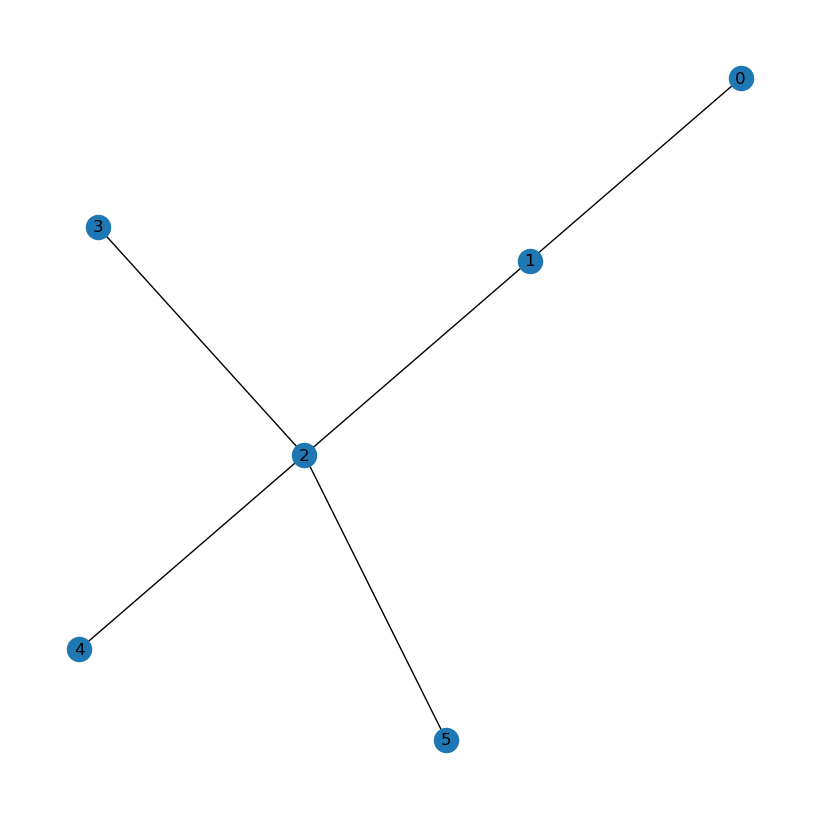

In [4]:
# Cell 4: Visualise the Pachner graph
import matplotlib.pyplot as plt

#Choose plotting format 
#...choose how to label the graph nodes with the below boolean toggles. Either:
# (1) Label with the respective node's triangulation isosigs.
# (2) Label with the number of tetrahedra in the node's triangulation.
# (3) Label with the node index.
#...the index labelling is the default, the isosig labelling takes priority over the number of tetrahedra.
plot_isosigs = False
plot_numtet = False

#Perform plotting (if graph sufficiently small to plot in feasible time)
if PG.number_of_nodes() < 500: 
    #Initialise the plot
    pos=nx.kamada_kawai_layout(PG)
    plt.figure('PG',figsize=(8,8))  
    
    #Plot the graph (labelling nodes with their respective index)
    if not plot_isosigs and not plot_numtet:
        nx.draw(PG,pos,with_labels=True)   
    
    #Plot with isosigs as node labels
    elif plot_isosigs:
        nx.draw(PG,pos,with_labels=False)
        nx.draw_networkx_labels(PG,pos,labels=nx.get_node_attributes(PG,'label')) #...add isosig labels (make above with_labels=False)

    #Plot with number of tetrahedra as node labels
    else: 
        numtet_labels = dict(list(enumerate([regina.engine.Triangulation3.fromSig(sig).countTetrahedra() for sig in T_list])))
        nx.draw(PG,pos,with_labels=False)
        nx.draw_networkx_labels(PG,pos,labels=numtet_labels) #...add number of tetrahedra as node labels
    
    #plt.savefig(f'./Data/PGData/PG_###.pdf') 
